# 임베딩 비교: 기존 vs BERT 하이브리드

두 가지 임베딩 방식 비교:
1. **기존 (fastText only)**: `movie_embeddings.parquet`
2. **BERT 하이브리드**: `movie_embeddings_bert.parquet`

비교 항목:
- 분포 특성 (분산, 이방성)
- 랜덤 쌍 코사인 유사도 분포
- PCA 시각화
- Nearest neighbor 품질

In [22]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# 프로젝트 설정
import sys
sys.path.insert(0, str(Path.cwd()))
from config import PROCESSED, PROJECT_ROOT

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10

In [23]:
# ============================================================
# 데이터 로드
# ============================================================
def load_embeddings(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """임베딩 parquet 로드 -> (movie_ids, embedding_matrix)"""
    df = pd.read_parquet(path)
    movie_ids = df["movieId"].to_numpy()
    emb = np.array(df["embedding"].tolist(), dtype=np.float32)
    return movie_ids, emb


# 경로 설정
EMB_ORIGINAL_PATH = PROCESSED.MOVIE_EMBEDDINGS_PARQUET
EMB_BERT_PATH = PROCESSED.MOVIE_EMBEDDINGS_BERT_PARQUET
CATALOG_PATH = PROCESSED.MOVIE_CATALOG_PARQUET

print(f"Original embedding: {EMB_ORIGINAL_PATH}")
print(f"BERT embedding: {EMB_BERT_PATH}")
print(f"Catalog: {CATALOG_PATH}")

Original embedding: /Users/jisoo/projects/thesis/carte_test/data/processed/movie_embeddings.parquet
BERT embedding: /Users/jisoo/projects/thesis/carte_test/data/processed/movie_embeddings_bert.parquet
Catalog: /Users/jisoo/projects/thesis/carte_test/data/processed/movie_catalog_flat.parquet


In [24]:
# 파일 존재 확인 및 로드
embeddings: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

if EMB_ORIGINAL_PATH.exists():
    ids_orig, E_orig = load_embeddings(EMB_ORIGINAL_PATH)
    embeddings["Original (fastText)"] = (ids_orig, E_orig)
    print(f"Original: {E_orig.shape}")
else:
    print(f"WARNING: {EMB_ORIGINAL_PATH} not found")

if EMB_BERT_PATH.exists():
    ids_bert, E_bert = load_embeddings(EMB_BERT_PATH)
    embeddings["BERT Hybrid"] = (ids_bert, E_bert)
    print(f"BERT Hybrid: {E_bert.shape}")
else:
    print(f"WARNING: {EMB_BERT_PATH} not found")
    print("Run apply_carte_movie_embeddings_bert.ipynb first!")

# 카탈로그 로드 (제목 표시용)
df_catalog = None
if CATALOG_PATH.exists():
    df_catalog = pd.read_parquet(CATALOG_PATH)
    print(f"Catalog: {len(df_catalog):,} movies")

Original: (86272, 300)
BERT Hybrid: (86272, 300)
Catalog: 86,272 movies


In [25]:
# ============================================================
# 진단 함수
# ============================================================
def compute_diagnostics(E: np.ndarray, name: str, sample_size: int = 20000) -> Dict:
    """임베딩 품질 진단 메트릭 계산"""
    rng = np.random.default_rng(42)
    n = min(len(E), sample_size)
    idx = rng.choice(len(E), size=n, replace=False)
    E_s = E[idx].copy().astype(np.float64)  # float64로 변환하여 수치 안정성 향상
    
    # NaN/Inf 처리
    if not np.isfinite(E_s).all():
        print(f"  [Warning] {name}: Found NaN/Inf values, replacing with 0")
        E_s = np.nan_to_num(E_s, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 정규화
    norms = np.linalg.norm(E_s, axis=1, keepdims=True)
    E_norm = E_s / (norms + 1e-12)
    
    # 1) 노름 통계
    norm_mean = float(norms.mean())
    norm_std = float(norms.std())
    
    # 2) 이방성 (평균 방향 쏠림)
    mean_dir = E_norm.mean(axis=0)
    anisotropy = float(np.linalg.norm(mean_dir))
    
    # 3) 차원별 분산
    dim_std = E_s.std(axis=0)
    dead_ratio = float((dim_std < 1e-4).mean())
    
    # 4) 랜덤 쌍 코사인 유사도
    pair_n = min(100000, n * 10)
    a_idx = rng.integers(0, n, size=pair_n)
    b_idx = rng.integers(0, n, size=pair_n)
    same = a_idx == b_idx
    b_idx[same] = (b_idx[same] + 1) % n
    
    pair_cos = np.sum(E_norm[a_idx] * E_norm[b_idx], axis=1)
    cos_mean = float(pair_cos.mean())
    cos_std = float(pair_cos.std())
    cos_p5 = float(np.percentile(pair_cos, 5))
    cos_p50 = float(np.percentile(pair_cos, 50))
    cos_p95 = float(np.percentile(pair_cos, 95))
    
    # 5) PCA effective rank - 분산 기반 계산 (SVD 없이)
    eff_rank = 1.0
    evr_1 = 1.0
    evr_10 = 1.0
    
    try:
        # 중심화
        E_centered = E_s - E_s.mean(axis=0)
        
        # 공분산 행렬의 고유값으로 분산비 계산 (더 안정적)
        # 샘플 수가 차원보다 많으면 공분산 행렬 사용
        if n > E_s.shape[1]:
            cov = np.cov(E_centered, rowvar=False)
            eigenvalues = np.linalg.eigvalsh(cov)
            eigenvalues = np.maximum(eigenvalues, 0)  # 음수 제거
            eigenvalues = eigenvalues[::-1]  # 내림차순 정렬
        else:
            # 샘플 수가 적으면 Gram matrix 사용
            gram = E_centered @ E_centered.T / (n - 1)
            eigenvalues = np.linalg.eigvalsh(gram)
            eigenvalues = np.maximum(eigenvalues, 0)
            eigenvalues = eigenvalues[::-1]
        
        # 분산비 계산
        total_var = eigenvalues.sum() + 1e-12
        var_ratio = eigenvalues / total_var
        
        # effective rank
        p = var_ratio / (var_ratio.sum() + 1e-12)
        p = p[p > 1e-12]  # 0에 가까운 값 제거 (log 안정성)
        eff_rank = float(np.exp(-(p * np.log(p)).sum()))
        
        evr_1 = float(var_ratio[0])
        evr_10 = float(var_ratio[:min(10, len(var_ratio))].sum())
        
    except Exception as e:
        print(f"  [Warning] {name}: Eigenvalue computation failed ({e}), using defaults")
    
    return {
        "name": name,
        "n_samples": n,
        "dim": E.shape[1],
        "norm_mean": norm_mean,
        "norm_std": norm_std,
        "anisotropy": anisotropy,
        "dead_dim_ratio": dead_ratio,
        "cos_mean": cos_mean,
        "cos_std": cos_std,
        "cos_p5": cos_p5,
        "cos_p50": cos_p50,
        "cos_p95": cos_p95,
        "eff_rank": eff_rank,
        "evr_1": evr_1,
        "evr_10": evr_10,
        "pair_cos_dist": pair_cos,  # 시각화용
    }

In [26]:
# ============================================================
# 진단 실행
# ============================================================
diagnostics = {}
for name, (ids, E) in embeddings.items():
    print(f"\nComputing diagnostics for: {name}")
    diag = compute_diagnostics(E, name)
    diagnostics[name] = diag

print("\nDone!")


Computing diagnostics for: Original (fastText)

Computing diagnostics for: BERT Hybrid
  [Warning] BERT Hybrid: Found NaN/Inf values, replacing with 0

Done!


In [27]:
# ============================================================
# 비교 테이블
# ============================================================
if len(diagnostics) >= 1:
    metrics = [
        ("Dimension", "dim"),
        ("Norm (mean)", "norm_mean"),
        ("Norm (std)", "norm_std"),
        ("Anisotropy (lower=better)", "anisotropy"),
        ("Dead dim ratio", "dead_dim_ratio"),
        ("Cosine mean (lower=better)", "cos_mean"),
        ("Cosine std (higher=better)", "cos_std"),
        ("Cosine p5", "cos_p5"),
        ("Cosine p50", "cos_p50"),
        ("Cosine p95", "cos_p95"),
        ("Effective rank (higher=better)", "eff_rank"),
        ("EVR@1 (lower=better)", "evr_1"),
        ("EVR@10 (lower=better)", "evr_10"),
    ]
    
    rows = []
    for label, key in metrics:
        row = {"Metric": label}
        for name, diag in diagnostics.items():
            val = diag.get(key, None)
            if isinstance(val, float):
                row[name] = f"{val:.4f}"
            else:
                row[name] = str(val)
        rows.append(row)
    
    df_compare = pd.DataFrame(rows)
    print("\n" + "="*60)
    print("EMBEDDING COMPARISON")
    print("="*60)
    display(df_compare)


EMBEDDING COMPARISON


,Metric,Original (fastText),BERT Hybrid
0,Dimension,300,300
1,Norm (mean),13.4292,13.4240
2,Norm (std),0.2176,0.2506
3,Anisotropy (lower=better),0.9751,0.9693
4,Dead dim ratio,0.0000,0.0000
5,Cosine mean (lower=better),0.9508,0.9392
6,Cosine std (higher=better),0.0695,0.0805
7,Cosine p5,0.8537,0.8167
8,Cosine p50,0.9701,0.9626
9,Cosine p95,0.9954,0.9935


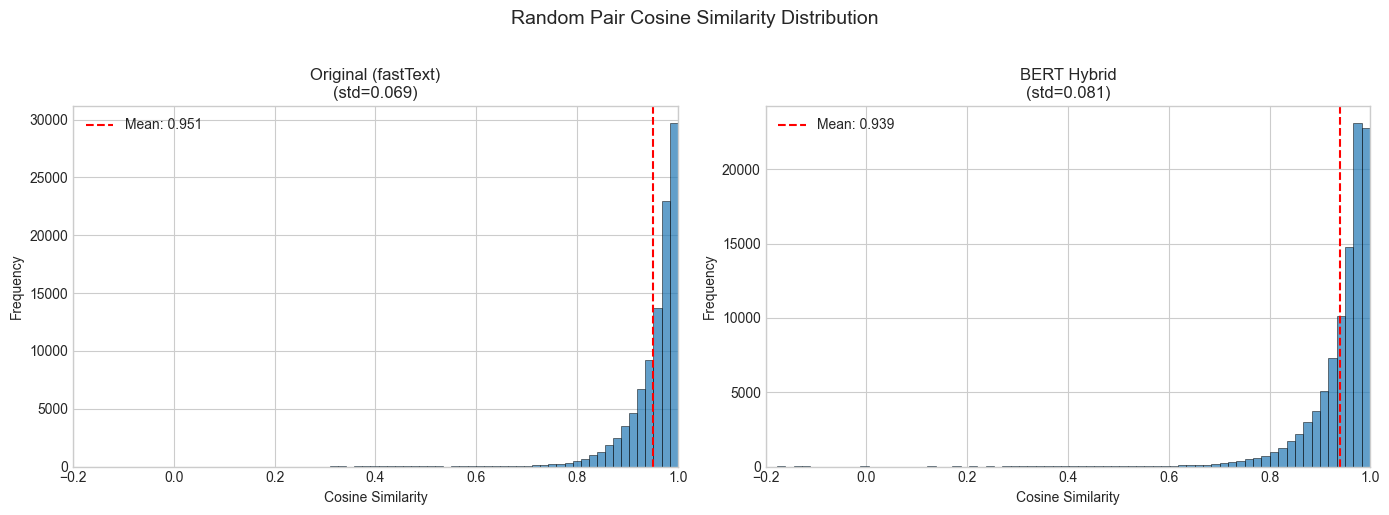

In [28]:
# ============================================================
# 코사인 유사도 분포 비교 (히스토그램)
# ============================================================
if len(diagnostics) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, (name, diag) in zip(axes, diagnostics.items()):
        cos_dist = diag["pair_cos_dist"]
        ax.hist(cos_dist, bins=100, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(cos_dist.mean(), color='red', linestyle='--', label=f'Mean: {cos_dist.mean():.3f}')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{name}\n(std={cos_dist.std():.3f})')
        ax.legend()
        ax.set_xlim(-0.2, 1.0)
    
    plt.suptitle('Random Pair Cosine Similarity Distribution', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
elif len(diagnostics) == 1:
    name, diag = list(diagnostics.items())[0]
    cos_dist = diag["pair_cos_dist"]
    
    plt.figure(figsize=(10, 5))
    plt.hist(cos_dist, bins=100, alpha=0.7, edgecolor='black', linewidth=0.5)
    plt.axvline(cos_dist.mean(), color='red', linestyle='--', label=f'Mean: {cos_dist.mean():.3f}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Random Pair Cosine Similarity\n(std={cos_dist.std():.3f})')
    plt.legend()
    plt.tight_layout()
    plt.show()

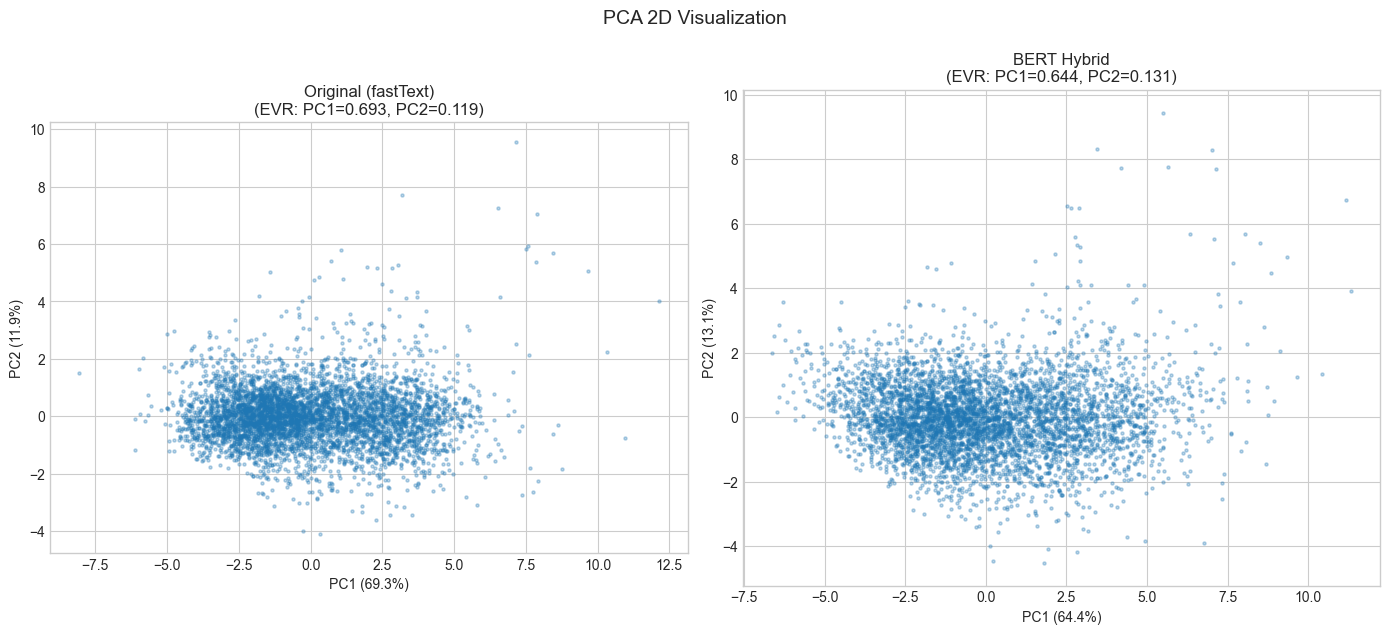

In [29]:
# ============================================================
# PCA 시각화 (2D)
# ============================================================
def plot_pca_2d(E: np.ndarray, name: str, sample_size: int = 5000, ax=None):
    """PCA 2D 시각화"""
    rng = np.random.default_rng(42)
    n = min(len(E), sample_size)
    idx = rng.choice(len(E), size=n, replace=False)
    E_s = E[idx]
    
    pca = PCA(n_components=2)
    E_2d = pca.fit_transform(E_s)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(E_2d[:, 0], E_2d[:, 1], alpha=0.3, s=5)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(f'{name}\n(EVR: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f})')
    ax.set_aspect('equal')
    
    return ax


if len(embeddings) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, (name, (ids, E)) in zip(axes, embeddings.items()):
        plot_pca_2d(E, name, ax=ax)
    plt.suptitle('PCA 2D Visualization', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
elif len(embeddings) == 1:
    name, (ids, E) = list(embeddings.items())[0]
    plot_pca_2d(E, name)
    plt.tight_layout()
    plt.show()

In [30]:
# ============================================================
# Nearest Neighbor 비교
# ============================================================
def find_nearest_neighbors(
    query_id: int,
    movie_ids: np.ndarray,
    E: np.ndarray,
    k: int = 5,
) -> List[Tuple[int, float]]:
    """주어진 영화의 k-nearest neighbors 찾기"""
    idx = np.where(movie_ids == query_id)[0]
    if len(idx) == 0:
        return []
    
    # NaN 처리
    E_clean = np.nan_to_num(E, nan=0.0, posinf=0.0, neginf=0.0)
    
    query_vec = E_clean[idx[0]].reshape(1, -1)
    sims = cosine_similarity(query_vec, E_clean)[0]
    
    # 자기 자신 제외하고 top-k
    top_indices = np.argsort(sims)[::-1][1:k+1]
    
    return [(int(movie_ids[i]), float(sims[i])) for i in top_indices]


def get_movie_title(movie_id: int, df_catalog: Optional[pd.DataFrame]) -> str:
    """영화 제목 조회"""
    if df_catalog is None:
        return f"ID:{movie_id}"
    
    # original_title 또는 title 컬럼 사용
    title_col = "original_title" if "original_title" in df_catalog.columns else "title"
    if title_col not in df_catalog.columns:
        return f"ID:{movie_id}"
    
    row = df_catalog[df_catalog["movieId"] == movie_id]
    if len(row) == 0:
        return f"ID:{movie_id}"
    return str(row[title_col].iloc[0])

In [31]:
# ============================================================
# 특정 영화에 대한 NN 비교
# ============================================================
# 테스트할 영화 ID들 (유명 영화 선택)
# MovieLens ID 기준
test_movie_ids = [
    1,      # Toy Story
    260,    # Star Wars: Episode IV
    318,    # Shawshank Redemption
    356,    # Forrest Gump
    593,    # Silence of the Lambs
]

if len(embeddings) >= 1:
    print("\n" + "="*80)
    print("NEAREST NEIGHBOR COMPARISON")
    print("="*80)
    
    for query_id in test_movie_ids:
        query_title = get_movie_title(query_id, df_catalog)
        print(f"\nQuery: {query_title} (ID: {query_id})")
        print("-" * 60)
        
        for name, (ids, E) in embeddings.items():
            if query_id not in ids:
                print(f"  [{name}] Movie not found")
                continue
            
            neighbors = find_nearest_neighbors(query_id, ids, E, k=5)
            print(f"  [{name}]")
            for nn_id, sim in neighbors:
                nn_title = get_movie_title(nn_id, df_catalog)
                print(f"    - {nn_title} (sim={sim:.4f})")
        print()


NEAREST NEIGHBOR COMPARISON

Query: Toy Story (ID: 1)
------------------------------------------------------------
  [Original (fastText)]
    - The Odd Job (sim=0.9996)
    - Masters of the Universe (sim=0.9996)
    - Red Heat (sim=0.9996)
    - The Neighbor (sim=0.9993)
    - 2010 (sim=0.9993)
  [BERT Hybrid]
    - The Twelve Chairs (sim=0.9994)
    - It's All Happening (sim=0.9994)
    - Alien Autopsy: (Fact or Fiction?) (sim=0.9993)
    - Jakten på Nyresteinen (sim=0.9993)
    - Operation Diplomat (sim=0.9992)


Query: Star Wars (ID: 260)
------------------------------------------------------------
  [Original (fastText)]
    - Variety Girl (sim=0.9993)
    - Hellcats of the Navy (sim=0.9986)
    - Slaves of Babylon (sim=0.9985)
    - Sabrina (sim=0.9983)
    - Shuffle Off to Buffalo (sim=0.9982)
  [BERT Hybrid]
    - Smile, Darn Ya, Smile! (sim=0.9968)
    - Bugs Bunny/Looney Tunes All-Star 50th Anniversary (sim=0.9955)
    - The Silent One (sim=0.9942)
    - Thinner (sim=0.9941)

In [32]:
# ============================================================
# 결론 요약
# ============================================================
if len(diagnostics) >= 2:
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    names = list(diagnostics.keys())
    d1, d2 = diagnostics[names[0]], diagnostics[names[1]]
    
    improvements = []
    
    # Anisotropy (낮을수록 좋음)
    if d2["anisotropy"] < d1["anisotropy"]:
        pct = (d1["anisotropy"] - d2["anisotropy"]) / d1["anisotropy"] * 100
        improvements.append(f"Anisotropy: {d1['anisotropy']:.4f} -> {d2['anisotropy']:.4f} ({pct:.1f}% improvement)")
    
    # Cosine mean (낮을수록 좋음 - 더 다양함)
    if d2["cos_mean"] < d1["cos_mean"]:
        pct = (d1["cos_mean"] - d2["cos_mean"]) / d1["cos_mean"] * 100
        improvements.append(f"Cosine mean: {d1['cos_mean']:.4f} -> {d2['cos_mean']:.4f} ({pct:.1f}% improvement)")
    
    # Effective rank (높을수록 좋음)
    if d2["eff_rank"] > d1["eff_rank"]:
        pct = (d2["eff_rank"] - d1["eff_rank"]) / d1["eff_rank"] * 100
        improvements.append(f"Effective rank: {d1['eff_rank']:.2f} -> {d2['eff_rank']:.2f} ({pct:.1f}% improvement)")
    
    # Cosine std (높을수록 좋음 - 더 다양함)
    if d2["cos_std"] > d1["cos_std"]:
        pct = (d2["cos_std"] - d1["cos_std"]) / d1["cos_std"] * 100
        improvements.append(f"Cosine std: {d1['cos_std']:.4f} -> {d2['cos_std']:.4f} ({pct:.1f}% improvement)")
    
    if improvements:
        print(f"\n{names[1]} shows improvements over {names[0]}:")
        for imp in improvements:
            print(f"  - {imp}")
    else:
        print(f"\nNo clear improvements detected.")
        print("Consider:")
        print("  - Using a larger/better BERT model")
        print("  - Different integration strategy")
        print("  - Fine-tuning the projection layer")


SUMMARY

BERT Hybrid shows improvements over Original (fastText):
  - Anisotropy: 0.9751 -> 0.9693 (0.6% improvement)
  - Cosine mean: 0.9508 -> 0.9392 (1.2% improvement)
  - Effective rank: 3.07 -> 3.46 (12.9% improvement)
  - Cosine std: 0.0695 -> 0.0805 (16.0% improvement)


In [33]:
# ============================================================
# 추가 분석: 장르별 클러스터링 품질 (선택사항)
# ============================================================
if df_catalog is not None and "genre_1" in df_catalog.columns and len(embeddings) >= 1:
    print("\n" + "="*60)
    print("GENRE CLUSTERING QUALITY (Intra-genre cosine similarity)")
    print("="*60)
    
    # 장르 매핑
    genre_map = df_catalog.set_index("movieId")["genre_1"].to_dict()
    
    for name, (ids, E) in embeddings.items():
        print(f"\n[{name}]")
        
        # NaN 처리 후 정규화
        E_clean = np.nan_to_num(E, nan=0.0, posinf=0.0, neginf=0.0)
        E_norm = E_clean / (np.linalg.norm(E_clean, axis=1, keepdims=True) + 1e-12)
        
        # 장르별 평균 intra-similarity
        genres = [genre_map.get(mid, None) for mid in ids]
        unique_genres = [g for g in set(genres) if g is not None][:10]  # 상위 10개
        
        for genre in sorted(unique_genres):
            genre_idx = np.array([i for i, g in enumerate(genres) if g == genre])
            if len(genre_idx) < 10:
                continue
            
            # 같은 장르 내 랜덤 쌍 샘플링
            rng = np.random.default_rng(42)
            n_pairs = min(1000, len(genre_idx) * 5)
            a_idx = rng.choice(genre_idx, size=n_pairs)
            b_idx = rng.choice(genre_idx, size=n_pairs)
            
            # 같은 인덱스면 다른 것으로 교체 (간단한 방법)
            same_mask = a_idx == b_idx
            n_same = same_mask.sum()
            if n_same > 0:
                # 새로운 랜덤 인덱스로 교체
                b_idx[same_mask] = rng.choice(genre_idx, size=n_same)
                # 여전히 같으면 그냥 무시 (확률 낮음)
            
            intra_cos = np.sum(E_norm[a_idx] * E_norm[b_idx], axis=1)
            print(f"  {genre:15s}: mean={intra_cos.mean():.4f}, std={intra_cos.std():.4f}, n={len(genre_idx):,}")


GENRE CLUSTERING QUALITY (Intra-genre cosine similarity)

[Original (fastText)]
  Animation      : mean=0.9310, std=0.0815, n=3,555
  Documentary    : mean=0.9438, std=0.1111, n=9,073
  Drama          : mean=0.9609, std=0.0385, n=22,256
  Family         : mean=0.9633, std=0.0462, n=1,468
  Fantasy        : mean=0.9461, std=0.0887, n=1,124
  History        : mean=0.9334, std=0.1036, n=596
  TV Movie       : mean=0.9730, std=0.0275, n=1,025
  Thriller       : mean=0.9628, std=0.0412, n=3,522
  War            : mean=0.9421, std=0.0614, n=777
  Western        : mean=0.9637, std=0.0420, n=1,140

[BERT Hybrid]
  Animation      : mean=0.9077, std=0.1280, n=3,555
  Documentary    : mean=0.9344, std=0.1063, n=9,073
  Drama          : mean=0.9510, std=0.0539, n=22,256
  Family         : mean=0.9525, std=0.0628, n=1,468
  Fantasy        : mean=0.9301, std=0.1240, n=1,124
  History        : mean=0.9224, std=0.1200, n=596
  TV Movie       : mean=0.9641, std=0.0395, n=1,025
  Thriller       : mean=